In [46]:
#Dataframe için :
import pandas as pd 
pd.options.mode.chained_assignment = None #pandas warning ignore
import numpy as np

#Veri görselleştirme ve analiz:
import matplotlib.pyplot as plt
import seaborn as sns

#Model:
import xgboost as xgb

#Error hesabı:
from sklearn.metrics import mean_squared_error


In [3]:
df = pd.read_csv("data.csv")
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


<AxesSubplot:title={'center':'saatlik enerji tüketimi(MW)'}, xlabel='Datetime'>

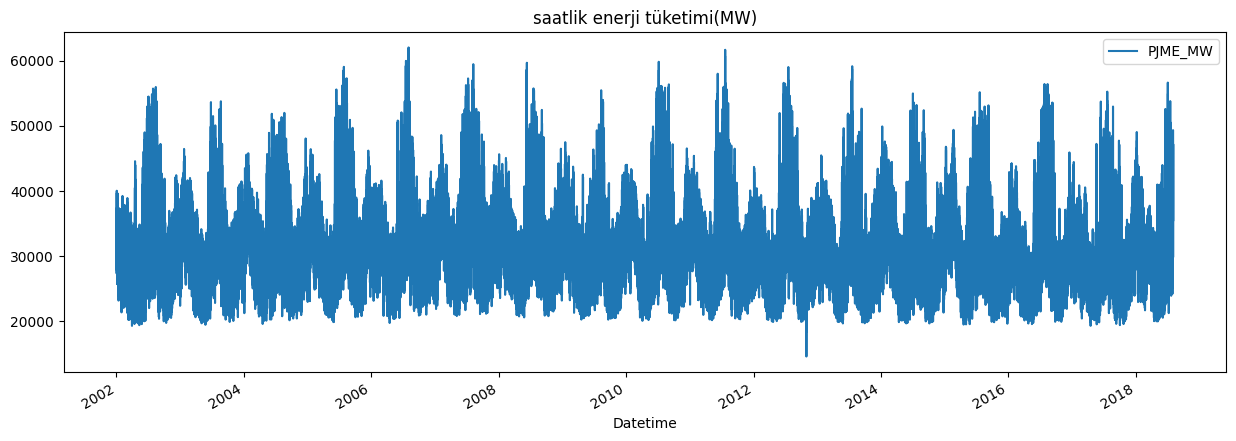

In [4]:
# normal sıralı indexi date-time çevirelim ki yıllık kullanım daha rahat görünsün.
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

df.plot(figsize=(15,5),title="saatlik enerji tüketimi(MW)")


In [5]:
df.index

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

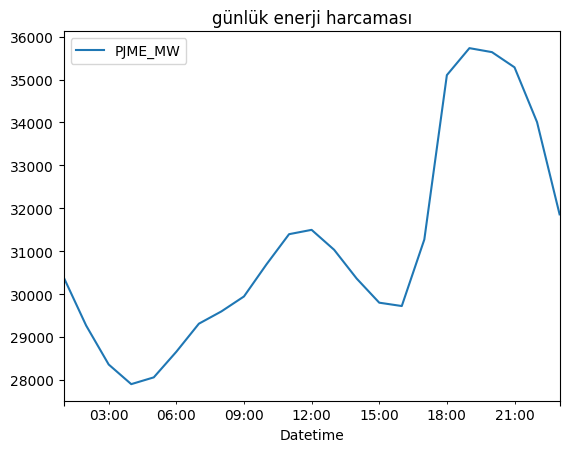

In [6]:
# GÜNLÜK:

gunluk = df.loc[ (df.index > "2002-01-01 00:00:00") & (df.index < "2002-01-02 00:00:00") ].plot(title="günlük enerji harcaması")
# göründüğü üzere biri büyük biri küçük günde 2 kere pik yapıyor.
# pikler yaklaşık öğle ve akşam 8 saatlerine denk geliyor.
# minimum kullanım gece 3-6 saatleri arasında.

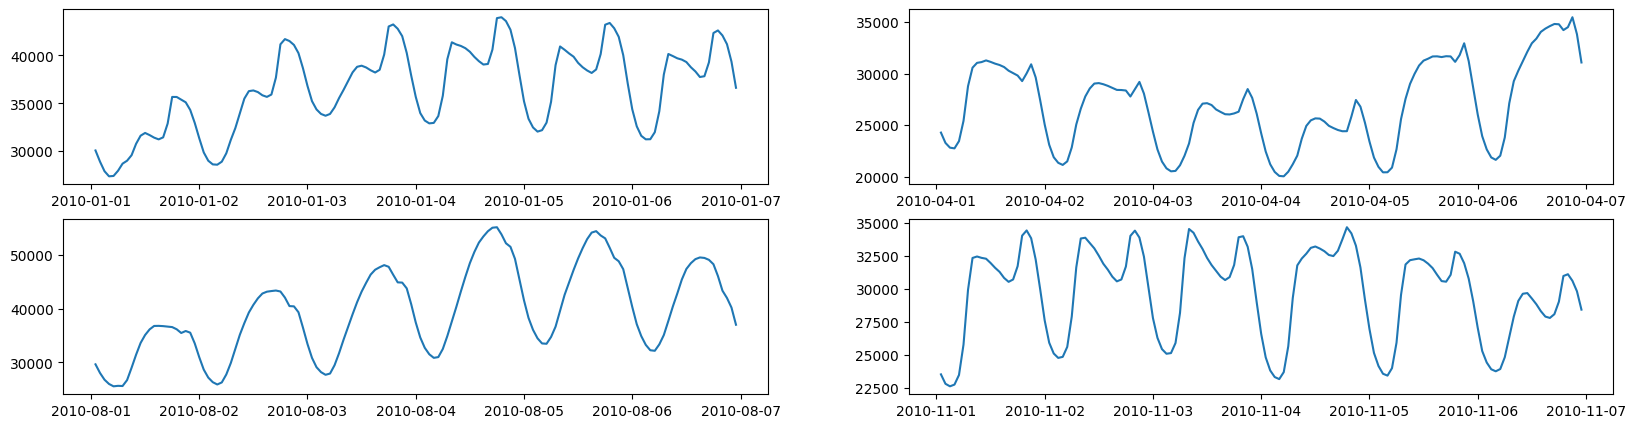

In [7]:
# HAFTALIK:

fig,axs = plt.subplots(2,2, figsize=(20,5))
haftalik1 = df.loc[ (df.index > "2010-01-01") & (df.index < "2010-01-07") ]
haftalik2 = df.loc[ (df.index > "2010-04-01") & (df.index < "2010-04-07") ]
haftalik3 = df.loc[ (df.index > "2010-08-01") & (df.index < "2010-08-07") ]
haftalik4 = df.loc[ (df.index > "2010-11-01") & (df.index < "2010-11-07") ]
haftalik1.sort_values(by='Datetime', ascending = True, inplace = True)
haftalik2.sort_values(by='Datetime', ascending = True, inplace = True)
haftalik3.sort_values(by='Datetime', ascending = True, inplace = True)
haftalik4.sort_values(by='Datetime', ascending = True, inplace = True)
axs[0,0].plot(haftalik1)
axs[0,1].plot(haftalik2)
axs[1,0].plot(haftalik3)
axs[1,1].plot(haftalik4)




#göründüğü üzere aynı yıl içinde farklı aylardaki haftalarda günlük görülen pikler arasındakı zaman ve boyut farkları değişebiliyor.


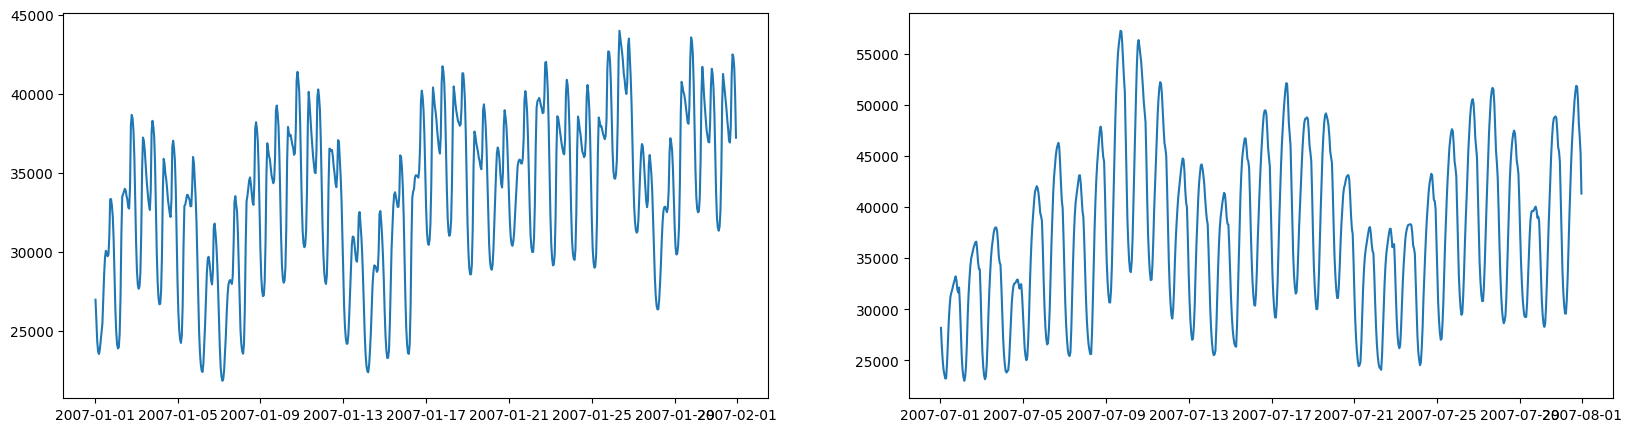

In [8]:
# AYLIK:
fig,axs = plt.subplots(1,2, figsize=(20,5))
aylik1 = df.loc[ (df.index > "2007-01-01") & (df.index < "2007-02-01") ]
aylik2 = df.loc[ (df.index > "2007-07-01") & (df.index < "2007-08-01") ]
aylik1.sort_values(by='Datetime', ascending = True, inplace = True)
aylik2.sort_values(by='Datetime', ascending = True, inplace = True)

axs[0].plot(aylik1)
axs[1].plot(aylik2)

# yaz ve kış aylarının piklerinin farkları belli oluyor.
# verilerin ortalamasını alırsak ortak bir çizgiyi takip ettiğini görebiliriz.

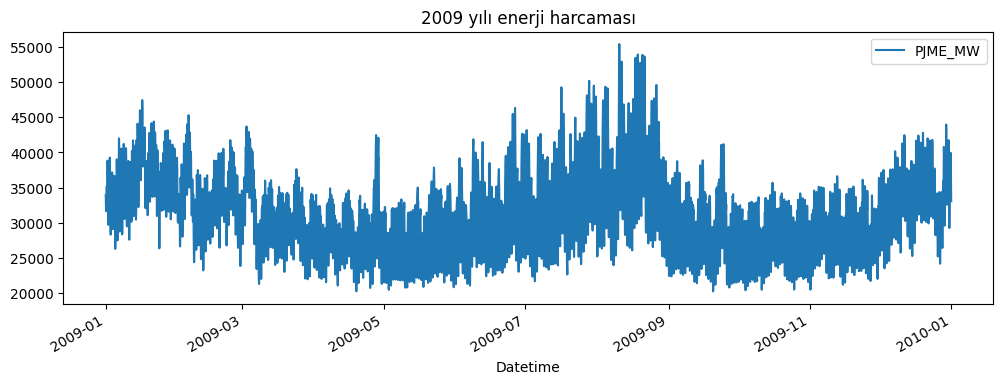

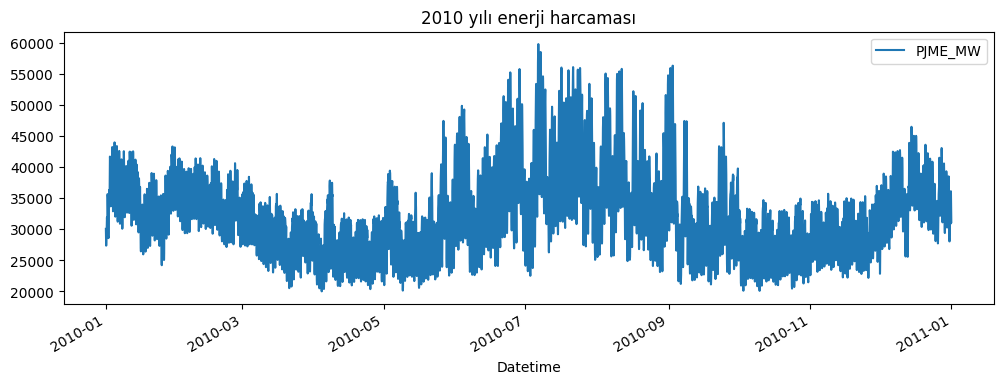

In [9]:
# SENELİK:
senelik1 = df.loc[ (df.index > "2009-01-01") & (df.index < "2010-01-01") ].plot(figsize=(12,4),title="2009 yılı enerji harcaması")
senelik1 = df.loc[ (df.index > "2010-01-01") & (df.index < "2011-01-01") ].plot(figsize=(12,4),title="2010 yılı enerji harcaması")

#ana şekil aynı olsada standart sapmalar da seneden seneye farklılık gösteriyor.

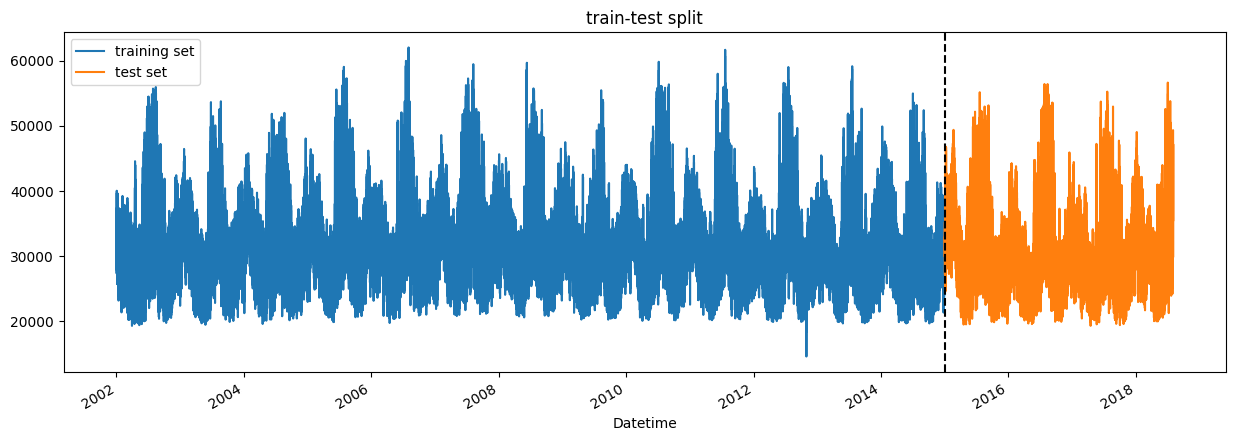

In [10]:
# train/test split:
train = df.loc[df.index < "01-01-2015"]
test = df.loc[df.index >= "01-01-2015"]

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label="Train",title="train-test split")
test.plot(ax=ax,label="Test")
ax.axvline("01-01-2015",color="black",ls="--")
ax.legend(["training set","test set"])
plt.show()

In [13]:
# ZAMAN SERİSİ ÖZELLİKLERİ:

def create_features(df):
    df["hour"] = df.index.hour
    df["year"] = df.index.year
    df["month"] = df.index.month
    df["dayofweek"] = df.index.day_of_week
    df["dayofyear"] = df.index.day_of_year
    df["quarter"] = df.index.quarter
    return df

df = create_features(df)
df.head()

,PJME_MW,hour,year,month,dayofweek,dayofyear,quarter
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,2002,12,1,365,4
2002-12-31 02:00:00,25147.0,2,2002,12,1,365,4
2002-12-31 03:00:00,24574.0,3,2002,12,1,365,4
2002-12-31 04:00:00,24393.0,4,2002,12,1,365,4
2002-12-31 05:00:00,24860.0,5,2002,12,1,365,4


<AxesSubplot:xlabel='hour', ylabel='PJME_MW'>

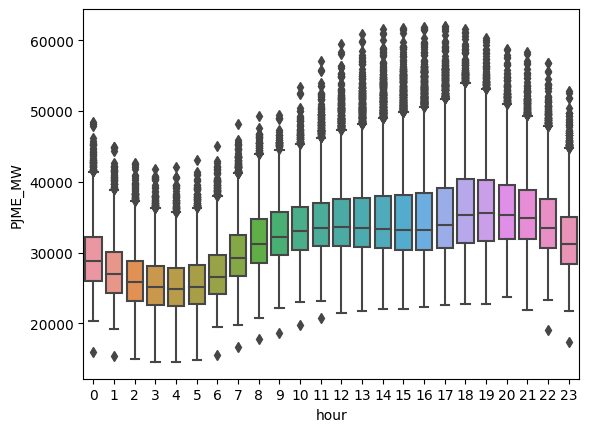

In [14]:
# ÖZELLİK / HARCANIM ÖZELLİKLERİ BOXPLOT:
sns.boxplot(data=df,x="hour",y="PJME_MW")

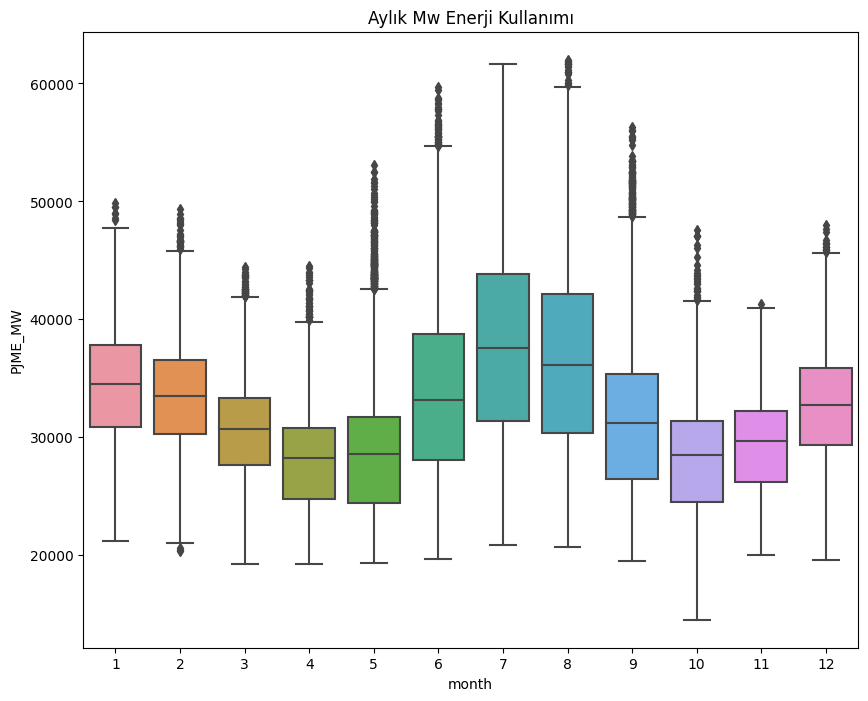

In [16]:
fig,ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df,x="month",y="PJME_MW")
ax.set_title("Aylık Mw Enerji Kullanımı")
plt.show()

In [31]:
# Model:

train = create_features(train)
test = create_features(test)

ozellikler = ['hour', 'year', 'month', 'dayofweek', 'dayofyear','quarter']

X_train = train[ozellikler]
y_train = train["PJME_MW"]
X_test = test[ozellikler]
y_test = test["PJME_MW"]

reg = xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=50, #eğer test seti daha gelişmezse erken durdur
                       learning_reate=0.01)
# rmse önce azalıp sonra tekrar artmaya başladı.
# bu overfitting göstergesi. düzeltmek için earyl_stopping_rounds ekledik ve learning_rate azalltık.
reg.fit(X_train,y_train,
        eval_set=[(X_train,y_train),(X_test,y_test)],
        verbose=100 ) #verbose:yorum satırı, kaç satırın gözükeceğini gösterir. model ile çalışırken True da bırakıyorum ki analiz edebileyim.

[19:47:59] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "learning_reate" } are not used.

[0]	validation_0-rmse:23192.08347	validation_1-rmse:22262.72116
[59]	validation_0-rmse:1940.87501	validation_1-rmse:4242.54387


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             learning_reate=0.01, max_bin=256, max_cat_threshold=64,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, predictor='auto', ...)

In [33]:
# Önemli Özellikler:

öö = pd.DataFrame(data=reg.feature_importances_,
            index=reg.feature_names_in_,
            columns=["Importance"])
öö.head()

,Importance
hour,0.448120
year,0.034630
month,0.277985
dayofweek,0.105957
dayofyear,0.133309


<AxesSubplot:title={'center':'özellik etkisi sıralaması'}>

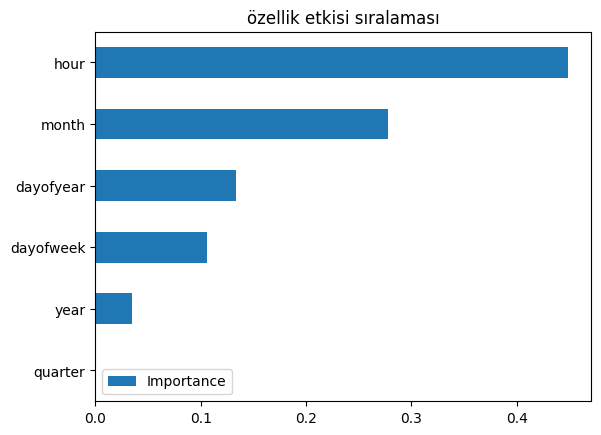

In [36]:
öö.sort_values("Importance").plot(kind="barh",title="özellik etkisi sıralaması")

In [38]:
# TEST VERİSİ TAHMİNİ:

test["prediction"] = reg.predict(X_test)
df = df.merge(test[["prediction"]],how="left",left_index=True,right_index=True)
df.head()
#test verimiz en sonda olduğu için baştaki veriler NaN gözüküyor.

,PJME_MW,hour,year,month,dayofweek,dayofyear,quarter,prediction
Datetime,,,,,,,,
2002-01-01 01:00:00,30393.0,1,2002,1,1,1,1,NaN
2002-01-01 02:00:00,29265.0,2,2002,1,1,1,1,NaN
2002-01-01 03:00:00,28357.0,3,2002,1,1,1,1,NaN
2002-01-01 04:00:00,27899.0,4,2002,1,1,1,1,NaN
2002-01-01 05:00:00,28057.0,5,2002,1,1,1,1,NaN


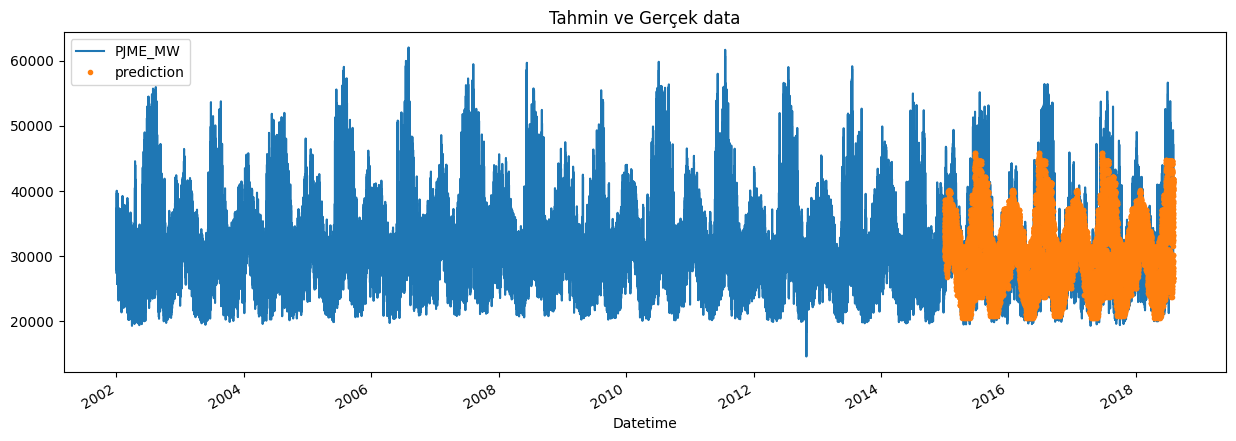

In [43]:
ax = df[["PJME_MW"]].plot(figsize=(15,5))
df["prediction"].plot(ax=ax,style=".")
plt.legend()
ax.set_title("Tahmin ve Gerçek data")
plt.show()

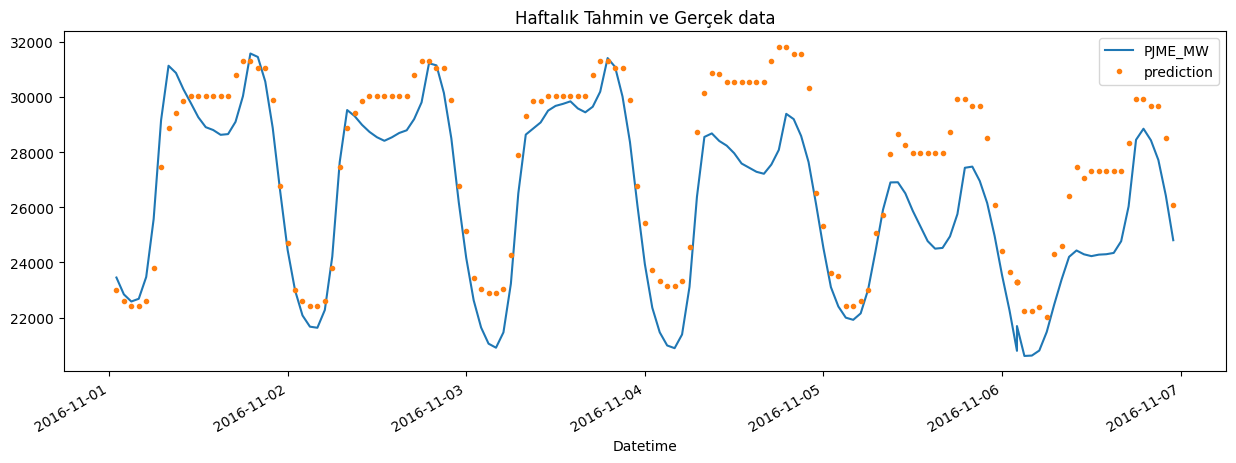

In [44]:
ax = df["PJME_MW"].loc[ (df.index > "2016-11-01") & (df.index < "2016-11-07") ].plot(figsize=(15,5))
df["prediction"].loc[ (df.index > "2016-11-01") & (df.index < "2016-11-07") ].plot(ax=ax,style=".")
plt.legend()
ax.set_title("Haftalık Tahmin ve Gerçek data")
plt.show()


In [48]:
score = np.sqrt(mean_squared_error(test["PJME_MW"],test["prediction"]))
print(f"root mean square error skoru: {score:0.2f}")

root mean square error skoru: 3763.35


In [52]:
# ERROR HESABI:

test["error"] = np.abs(test["PJME_MW"]-test["prediction"])

#veriyi günlere göre gruplayalımve sıralayalım:

test["date"] = test.index.date
test.groupby("date")["error"].mean().sort_values(ascending=False).head()

date
2016-08-13    14026.037760
2016-08-14    13533.325846
2016-09-10    13042.321940
2016-09-09    11385.571289
2015-02-20    10935.253174
Name: error, dtype: float64

In [54]:
test.groupby("date")["error"].mean().sort_values(ascending=True).head()

date
2017-04-22    428.334717
2016-09-27    455.130859
2018-05-19    458.394450
2016-04-04    461.127523
2017-05-06    468.640055
Name: error, dtype: float64